# Sparsity and L1 Regularization

In [39]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [40]:
def preprocess_features(california_housing_dataframe):
    """
    Prepares input features from CA housing dataset
    Args:
        california_housing_dataframe: A 'DataFrame' holding CA housing data
    Returns:
        A 'DataFrame' containing features to be used for model, this includes synthetic features
    """
    selected_features = california_housing_dataframe[
        [
            "latitude",
            "longitude",
            "housing_median_age",
            "total_rooms",
            "total_bedrooms",
            "population",
            "households",
            "median_income"
    ]]
    
    preprocess_features = selected_features.copy()
    preprocess_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return preprocess_features

In [41]:
def preprocess_targets(california_housing_dataframe):
    """
    Prepare target features from CA housing dataset
    Args:
        california_housing_dataframe: A 'DataFrame' holding CA housing data
    Returns:
        A 'DataFrame' containing target features
    """
    df = pd.DataFrame()
    df["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    return df

In [42]:
# split data into training/validation
training_examples = preprocess_features(california_housing_dataframe).head(12000)
training_targets = preprocess_targets(california_housing_dataframe).head(12000)
validation_examples = preprocess_features(california_housing_dataframe).tail(5000)
validation_targets = preprocess_targets(california_housing_dataframe).tail(5000)

In [43]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Trains a linear regression model
    
    Args:
        features: A 'DataFrame' of features
        targets: A 'DataFrame' of targets
        batch_size: Size of batches
        shuffle: Whether or not to shuffle data
        num_epochs: Number of epochs for which dat should be repeated, None = indefinitely
    Features:
        A tuple (features, targets) for next data batch
    """

    features = {key:np.array(value) for key,value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds.shuffle(10000)
    
    features,labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [44]:
def get_quantile_based_buckets(feature_values, num_buckets):
    quantiles = feature_values.quantile(
        [(i+1)/(num_buckets + 1.) for i in range(num_buckets)])
    return [quantiles[q] for q in quantiles.keys()]

In [45]:
def construct_feature_columns():
    """
    Construct the TensorFlow feature columns
    
    Returns:
        Set of feature columns
    """
    bucketized_households = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("households"),
        boundaries=get_quantile_based_buckets(training_examples["households"], 10))
    bucketized_longitude = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("longitude"),
        boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
    bucketized_latitude = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("latitude"),
        boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("housing_median_age"),
        boundaries=get_quantile_based_buckets(
          training_examples["housing_median_age"], 10))
    bucketized_total_rooms = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("total_rooms"),
        boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
    bucketized_total_bedrooms = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("total_bedrooms"),
        boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
    bucketized_population = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("population"),
        boundaries=get_quantile_based_buckets(training_examples["population"], 10))
    bucketized_median_income = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("median_income"),
        boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("rooms_per_person"),
        boundaries=get_quantile_based_buckets(
          training_examples["rooms_per_person"], 10))
    
    long_x_lat = tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)
    
    feature_columns = set([
        long_x_lat,
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_total_rooms,
        bucketized_total_bedrooms,
        bucketized_population,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person])
    return feature_columns

### Calculate model size

In [46]:
def model_size(estimator):
    variables = estimator.get_variable_names()
    size = 0
    for variable in variables:
        if not any(x in variable
                      for x in ['global_step',
                                'centered_bias_weight',
                                'bias_weight',
                                'Ftrl']
                        ):
            size += np.count_nonzero(estimator.get_variable_value(variable))
    return size        

## Task 1: Find a good regularization coefficient

In [49]:
def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """
    Train a linear classifier model
    
    Args:
        learning_rate: A 'float', the learning rate
        regularization_strength: A 'float', indicates the strength of the L1 regularization.
            Value of 0.0 results in no regularization
        steps: A non-zero 'int', number of training steps to take
        batch_size: A non-zero 'int', the batch size
        feature_columns: A 'set' specifying which columns to use as input features
        training_examples: A 'DataFrame' containing input features to be used for training
        training_targets: A 'DataFrame' containing target features for training
        validation_examples: A 'DataFrame' containing input features to be used for validation
        validation_targets: A 'DataFrame' containing target features for validation
    Returns:
        A 'LinearClassifier' model that has been trained on the data
    """
    
    periods = 7
    steps_per_period = steps / periods
    target_col = "median_house_value_is_high"
    
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, 
                                         l1_regularization_strength=regularization_strength)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(feature_columns, optimizer=my_optimizer)
    
    training_input_fn = lambda: my_input_fn(training_examples, 
                                            training_targets[target_col],
                                            batch_size=batch_size)
    predictions_training_input_fn = lambda: my_input_fn(training_examples, 
                                                        training_targets[target_col], 
                                                        shuffle=False, 
                                                        num_epochs=1)
    predictions_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[target_col], 
                                                    shuffle=False, 
                                                    num_epochs=1)
    print("Training model...")
    print("LogLoss (validation):")
    training_log_losses = []
    validation_log_losses = []
    for period in range(0,periods):
        
        linear_classifier.train(
            input_fn=training_input_fn, 
            steps=steps_per_period)
        
        # calculate probabilities
        training_probabilities = linear_classifier.predict(input_fn=predictions_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
        
        validation_probabilities = linear_classifier.predict(input_fn=predictions_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
        
        # compute training & validation losses
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        
        print("    period %02d : %0.2f" % (period, validation_log_loss))
        
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished")
    
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()
    
    return linear_classifier

Training model...
LogLoss (validation):
    period 00 : 0.34
    period 01 : 0.30
    period 02 : 0.28
    period 03 : 0.27
    period 04 : 0.27
    period 05 : 0.26
    period 06 : 0.26
Model training finished
Model size: 536


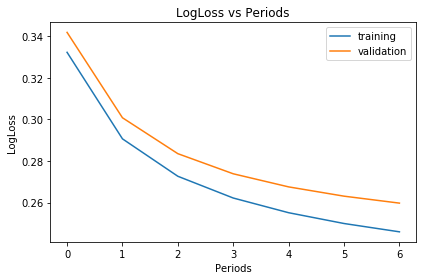

In [50]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1, 
    regularization_strength=1.0, 
    steps=300, 
    batch_size=100, 
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

Training model...
LogLoss (validation):
    period 00 : 0.32
    period 01 : 0.29
    period 02 : 0.27
    period 03 : 0.27
    period 04 : 0.26
    period 05 : 0.26
    period 06 : 0.26
Model training finished
Model size: 712


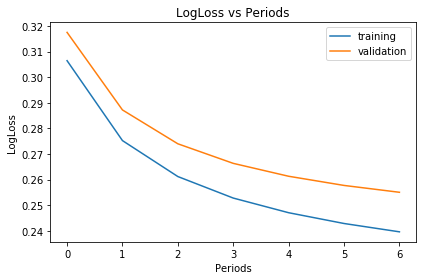

In [51]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1, 
    regularization_strength=0.1, 
    steps=300, 
    batch_size=100, 
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

Training model...
LogLoss (validation):
    period 00 : 0.38
    period 01 : 0.32
    period 02 : 0.30
    period 03 : 0.29
    period 04 : 0.28
    period 05 : 0.27
    period 06 : 0.27
Model training finished
Model size: 368


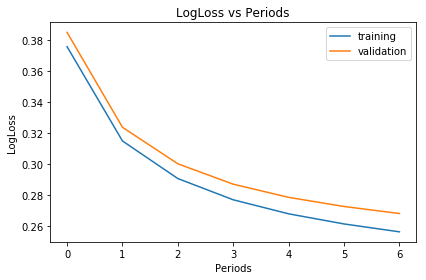

In [52]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1, 
    regularization_strength=3.0, 
    steps=300, 
    batch_size=100, 
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))